# Distribution computation in C# accessed via REST-API for multiple events having multiple weighted outcomes

Computing the distribution allows to modell **game design' specific payout-profiles**.
A general formula allows to determine the exact distribution on equally-distributed outcomes. A cylce-evaluation further allows to consider weighted-outcomes. With the help of the exact distribution the RTP can be controlled exactly. Furthermore, modifying the outcome-probabilities resp. weights allows to fine-tune the RTP and additionally, tune the [**game behaviour**](https://nbviewer.jupyter.org/github/Gordi33/The-Laws-of-the-Game/blob/master/PlayersSurvivalWhenThrowingDices.ipynb). It is also shown that if the probabilities resp. weights fluctuate while keeping the payout-profile constant that the RTP increases with the volatility of the weights. This is an important insight, if probabilities are only approximations resp. **implied probabilities** and not priori probability then the risk of having a higher RTP increases with the volatility.
 
 - Part 3: Deriving a general formula for a fixed number of equally-distributed outcomes for each event. Creating a game specific payout for events having equally-distributed outcomes based on the distribution.
 - Part 4: Cycle evaluation for a fixed number of events with weighted-outcomes in **C# accessed via REST-API**. Creating a game specific payout for events having weighted outcomes based on the distribution. Here,
 - Part5: RTP'impact of the different szenarios for increased volatility on the weights.

# Imports

In [1]:
import sys
sys.path.insert(0, 'lib\\')
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import scipy.special
import requests
from timeit import default_timer as timer
import urllib3
urllib3.disable_warnings()
import json
import random

# Deriving a general formula for a fixed number of events with equally-distributed outcomes
Part 3: Deriving a formula for computing the hits and the probabilities for a fixed number of dices, having a fixed number of equally-distributed outcomes.

For getting a better modelling understanding it is recommended to read [**CombinatorialThinking**](https://nbviewer.jupyter.org/github/Gordi33/Mathematical-Problems/blob/master/CombinatorialThinking%20.ipynb).

Let numOutcomes be the number of outcomes for each event and let numEvent be the number of events resp. dices.

 - The total cycle represents all combinations and can be evaluated by:

$$ totalCycle = {numOutcomes}^{numEvents}$$

For example, having 9 dices and each dice has 10 different outcomes leads to a total cycle of:

In [2]:
numEvents = 9
numOutcomes = 10
totalCycle = numOutcomes**numEvents
print(f"{totalCycle:,}")

1,000,000,000


The number of hits, denoted by k, can be evaluated by:
 
$$hits(k) = \binom{numEvents}{k} * {(numOutcomes-1)}^{(numEvents - k)}$$

--- 
This fact derives out of the following:
 1. Firstly, the number of hits resp. correct scores out of a given number of events is determined by the binomial coefficient. For example, having 2 hits on 9 dices with 10 outcomes leads to 36 different hit-combinations:

$$\binom{9}{2} = 36$$

 2. Secondly, for each hit-combination, the other dices need to cycle through all no-hit-combinations i.e., which do not lead to another hit. The number of no-hits on a dice is simply (numOutcomes - 1) and the number of dices, which show no-hit is (numEvent - k). Continuing with the example determines 7 no-hits dices and, on each 9 outcomes with no-hit:

$${(10-1)}^{(9 - 2)} = {(9)}^{(7)} = 4,782,969 $$

 3. Thirdly, the product determines the total success-hits within the cycle. For 2 hits with 9 dices having 10 outcomes:
   
$$\binom{9}{2} * {(10-1)}^{(9 - 2)} = 36 * 4,782,969 = 172,186,884 $$

---

Summing up all hits, for k = 0,...,numEvents; leads to

$$ totalCycle = {numOutcomes}^{numEvents} = \sum_{k=0}^{numEvents} \binom{numEvents}{k} * {(numOutcomes-1)}^{(numEvents - k)}$$ 


The probability of having k hits is then simply the ratio:

$$P(X=k) = \frac{hits(k)}{totalCycle} = \frac{\binom{numEvents}{k} * {(numOutcomes-1)}^{(numEvents - k)}}{{numOutcomes}^{numEvents}}$$
  

Continuing with the example, the probability of having 2 hits wiht 9 dices with 10 outcomes:
  
$$P(X=2) = \frac{\binom{9}{2} * {(10-1)}^{(9 - 2)}}{{10}^{9}} = 0.172186884 $$

In [3]:
temp = [[0 for x in range(numEvents+1)] for y in range(5)]
acc_hits = 0

for i in range(numEvents+1):
    temp[0][i] = scipy.special.binom(numEvents, i)
    temp[1][i] = (numOutcomes-1)**(numEvents - i)
    temp[2][i] = temp[0][i] * temp[1][i]
    acc_hits = acc_hits + temp[2][i] 
    temp[3][i] = acc_hits
    temp[4][i] = temp[2][i] *1.0 / totalCycle * 1.0

pd.options.display.float_format = '{:,.0f}'.format  
df = pd.DataFrame(temp).transpose().rename(columns={0: "Number of different combinations of hits, which lead to k hits", 
                                               1: "Number of different combinations of no-hits",
                                               2: "Total hits for k",
                                               3: "Accumulated hits", 
                                               4: "P(X)"})
df['P(X)'] = df['P(X)'].map('{:,.9f}'.format)
df

,"Number of different combinations of hits, which lead to k hits",Number of different combinations of no-hits,Total hits for k,Accumulated hits,P(X)
0,1,"387,420,489","387,420,489","387,420,489",0.387420489
1,9,"43,046,721","387,420,489","774,840,978",0.387420489
2,36,"4,782,969","172,186,884","947,027,862",0.172186884
3,84,"531,441","44,641,044","991,668,906",0.044641044
4,126,"59,049","7,440,174","999,109,080",0.007440174
5,126,"6,561","826,686","999,935,766",0.000826686
6,84,729,"61,236","999,997,002",0.000061236
7,36,81,"2,916","999,999,918",0.000002916
8,9,9,81,"999,999,999",0.000000081
9,1,1,1,"1,000,000,000",0.000000001


## Creating a game specific payout for events having equally-distributed outcomes based on the distribution

Part 3.1.: Creating a game based on the distribution allows to award a specific win to each category. Each category has its probability density due to the previous computation. With a given win and a given probability the category's **return-to-player** can be computed. The game's stake is 1 and game's **return-to-player** should be <100%.

In [4]:
payouts = [0.0,0.0,1.0,5.0,50.0,100.0,1000.0,10000.0,100000.0,1000000.0]
df['Payouts'] = payouts
df

,"Number of different combinations of hits, which lead to k hits",Number of different combinations of no-hits,Total hits for k,Accumulated hits,P(X),Payouts
0,1,"387,420,489","387,420,489","387,420,489",0.387420489,0
1,9,"43,046,721","387,420,489","774,840,978",0.387420489,0
2,36,"4,782,969","172,186,884","947,027,862",0.172186884,1
3,84,"531,441","44,641,044","991,668,906",0.044641044,5
4,126,"59,049","7,440,174","999,109,080",0.007440174,50
5,126,"6,561","826,686","999,935,766",0.000826686,100
6,84,729,"61,236","999,997,002",0.000061236,"1,000"
7,36,81,"2,916","999,999,918",0.000002916,"10,000"
8,9,9,81,"999,999,999",0.000000081,"100,000"
9,1,1,1,"1,000,000,000",0.000000001,"1,000,000"


For each hit-category a fictious payout based on the game's distribution is defined. The **hold** resp. margin, which is defined by 1-RTP is achieved by downgrading each hit-category further. 

The RTP is then simply defined by:


$$ RTP = \sum_{k=0}^{numEvents} Payouts(k) * P(X=k)$$   


In [5]:
df['RTP of k hits'] = df['Payouts'].astype(float) * df['P(X)'].astype(float)
df['RTP of k hits'] = df['RTP of k hits'].map('{:,.9f}'.format)
df
print('RTP =', df['RTP of k hits'].astype(float).sum())

RTP = 0.949565404


The next chapter shows a solution considering weighted outcomes. Weighted outcomes allow to consider events with different outcome-probabilities, which is a more flexible and realistical approach.
Additionally, the RTP and the [**game behaviour**](https://nbviewer.jupyter.org/github/Gordi33/The-Laws-of-the-Game/blob/master/PlayersSurvivalWhenThrowingDices.ipynb) can be modified via this.

 - Increasing the RTP can be achieved via increasing the probabilities of the categories which have a return.

# Cycle evaluation for a fixed number of events with weighted-outcomes in C# accessed via REST-API
Part 4: Applying the cycle-evaluation in **C# accessed via REST-API** with szenario analysis for the weights. 
What happens with the RTP, if the events aren't equally-distributed ?

How does the algorithm in C# work ?
The algorithm expects for each event an array with equal length for all events.

Let the events be defined by *j*=1,...,*numEvents* and 
the event' outcomes by *i*=1,...,*numOutcomes*. 

This array represents the event' weights and the array' index is the according outcome. The weights need to be positive integer values. The events and their weights are set up as an array of Json-objects (expected input). 

Algorithm:
 1. Weights for each event are normalised. For each event the normalisation is applied via

$$ P(i^{th} \hspace{2mm}  outcome \hspace{2mm} of \hspace{2mm} j^{th} \hspace{2mm} event) =  \frac{Weight(i,j)}{\sum_{i=1}^{numOutcomes}Weight(i,j)}$$   

 2. For each event the outcome with the maximum outcome' probability is chosen. If there is more than one maximum then the one with the lowest index is chosen. This combination of maximum outcome'probability represents the comabination, which is considered as the correct one. Let this combination be maximum likelihood estimation' combination denoted with MLE-combination.
 
 
 3. The total-cycle is evaluated.  

$$ totalCycle = {numOutcomes}^{numEvents}$$

    Note that the time complexity is O(numOutcomes^numEvents).
    Each combinations' probability is added to the category of correct hits according the MLE-combination as well as the correct hits.
    
    $$ totalCycle = {numOutcomes}^{numEvents}$$
   
 4. Pseudo code
 
    do 
    {
          computeCombinationProbability()
          computeCombinationHits()
          addProbabilityToTheCorrectNumberOfHitsCategory()
          incrementHitsCategoryForTheCorrectNumberOfHitsByOne()
          getNextCombinationInCycle()    
    } while (totalCycleIsNotCompletedYet);
    
    


## Cycle evaluation for equally-distrubuted weights
Part 4.1: Creating a JSON-object with the weights, defining the post-request and converting the output to a dataframe.

In [6]:
def getJsonEvents(): 
    events  = []
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    events.append({ "weights": [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]})
    return events

events = getJsonEvents()

In [7]:
#def getRequestsObject(url):
#    start = timer()
#    response = requests.get(url, verify=False)
#    end = timer()
#    print('Time in seconds: ', end - start)
#    return json.loads(response.text)

#responseJson = postRequestsObject('https://localhost:44339/api/Distribution')

In [8]:
def postRequestsObject(url, events):
    start = timer()
    response = requests.post(url, json = events, verify=False)
    end = timer()
    print('Time in seconds: ', end - start)
    return json.loads(response.text)

In [9]:
postRequestsObjectEqDist = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  19.16124450000001


In [10]:
def convertJsonIntoDataFrame(responseJson, numberOfEvents, payouts):
    df_weighted = pd.DataFrame([responseJson[i]['correctEventsCategory'] for i in range(0,numberOfEvents)]).rename(columns={0: "CorrectEventsCategory"})
    df_weighted['Probability'] = [responseJson[i]['probability'] for i in range(0,numberOfEvents)]
    df_weighted['Hits'] = [responseJson[i]['hits'] for i in range(0,numberOfEvents)]
    df_weighted['Probability'] = df_weighted['Probability'].astype(float).map('{:,.15f}'.format)
    df_weighted['Payouts'] = payouts
    df_weighted['RTP_of_k_hits'] = df_weighted['Payouts'].astype(float) * df_weighted['Probability'].astype(float)
    df_weighted['RTP_of_k_hits'] = df_weighted['RTP_of_k_hits'].map('{:,.15f}'.format)
    return df_weighted

In [11]:
df_weighted_equally = convertJsonIntoDataFrame(postRequestsObjectEqDist, len(events)+1, payouts)
df_weighted_equally

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.387420492615447,387420489,0,0.000000000000000
1,1,0.387420492615447,387420489,0,0.000000000000000
2,2,0.172186883914551,172186884,1,0.172186883914551
3,3,0.044641043981686,44641044,5,0.223205219908430
4,4,0.007440174000944,7440174,50,0.372008700047200
5,5,0.000826686000008,826686,100,0.082668600000800
6,6,0.000061236000000,61236,"1,000",0.061236000000000
7,7,0.000002916000000,2916,"10,000",0.029160000000000
8,8,0.000000081000000,81,"100,000",0.008100000000000
9,9,0.000000001000000,1,"1,000,000",0.001000000000000


Figures match the theoretical figures out of (3).

In [12]:
print('Probability =', round(df_weighted_equally['Probability'].astype(float).sum(),4))
print('Hits        =', round(df_weighted_equally['Hits'].astype(float).sum(),4))
print('RTP         =', round(df_weighted_equally['RTP_of_k_hits'].astype(float).sum(),18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 0.949565403870981


With equally weights for all outcomes the RTP is 94,96%.

## Cycle evaluation for modified weights -  weights fluctuate by +/- 1.
Assuming that the weights fluctuate by +/- 1. Having that super low flucatuation, what is the impact on the RTP ?

In [13]:
delta = 1
def getJsonEvents(): 
    events  = []
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    return events

In [14]:
events = getJsonEvents()
events

[{'weights': [1000, 1000, 999, 999, 999, 1000, 1000, 1001, 1001, 1001]},
 {'weights': [1000, 1001, 1000, 1000, 1000, 1001, 999, 999, 1000, 1000]},
 {'weights': [999, 1000, 1000, 1001, 1000, 999, 999, 999, 999, 1001]},
 {'weights': [1000, 1000, 1001, 999, 1001, 1001, 1000, 999, 1000, 999]},
 {'weights': [1000, 999, 1000, 999, 1001, 1001, 1000, 1001, 1001, 999]},
 {'weights': [1001, 1001, 1001, 1001, 1000, 1001, 1000, 1000, 1001, 999]},
 {'weights': [1000, 999, 999, 1000, 1001, 999, 1001, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 999, 1000, 999, 1001, 1001, 999, 1001, 1001]},
 {'weights': [1000, 999, 1001, 999, 1001, 1001, 999, 1001, 999, 1001]}]

In [15]:
responseJsonSz1 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.789558


In [16]:
df_weightedSz1 = convertJsonIntoDataFrame(responseJsonSz1, len(events)+1, payouts)
df_weightedSz1

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.387050444492090,387420489,0,0.000000000000000
1,1,0.387461431612222,387420489,0,0.000000000000000
2,2,0.172387934437152,172186884,1,0.172387934437152
3,3,0.044740624792346,44641044,5,0.223703123961730
4,4,0.007464688584522,7440174,50,0.373234429226100
5,5,0.000830290525672,826686,100,0.083029052567200
6,6,0.000061568306564,61236,"1,000",0.061568306564000
7,7,0.000002934937152,2916,"10,000",0.029349371520000
8,8,0.000000081612596,81,"100,000",0.008161259600000
9,9,0.000000001008633,1,"1,000,000",0.001008633000000


In [17]:
print('Probability =', round(df_weightedSz1['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSz1['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSz1['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 0.952442110876182


With a weight fluctuation of +/-1 of intially 1000 the RTP increased from 94,96% to 95,24%.

## Cycle evaluation for modified weights -  weights fluctuate by +/- 10.
Assuming that the weights fluctuate by +/- 10. Having that low flucatuation, what is the impact on the RTP ?

In [18]:
delta = 10
def getJsonEvents(): 
    events  = []
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    return events

In [19]:
events = getJsonEvents()
events

[{'weights': [1006, 993, 1002, 993, 999, 994, 998, 1008, 1009, 1003]},
 {'weights': [1004, 995, 1010, 990, 1008, 1003, 991, 996, 997, 1001]},
 {'weights': [994, 996, 997, 997, 992, 1000, 994, 1000, 998, 1006]},
 {'weights': [1009, 998, 999, 993, 1000, 1002, 990, 1006, 1010, 995]},
 {'weights': [1001, 1001, 995, 990, 990, 1006, 996, 994, 990, 995]},
 {'weights': [997, 1004, 998, 1006, 999, 992, 1000, 990, 990, 1006]},
 {'weights': [1004, 1009, 1005, 1003, 990, 998, 996, 1006, 1007, 998]},
 {'weights': [998, 1009, 990, 1004, 1003, 993, 1004, 994, 999, 1002]},
 {'weights': [995, 991, 1008, 991, 1007, 991, 1003, 1002, 1005, 992]}]

In [20]:
responseJsonSz10 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.3770935


In [21]:
df_weightedSz10 = convertJsonIntoDataFrame(responseJsonSz10, len(events)+1, payouts)
df_weightedSz10

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.383914086587635,387420489,0,0.000000000000000
1,1,0.387794389109083,387420489,0,0.000000000000000
2,2,0.174095044368292,172186884,1,0.174095044368292
3,3,0.045591934865381,44641044,5,0.227959674326905
4,4,0.007675453487304,7440174,50,0.383772674365200
5,5,0.000861447348157,826686,100,0.086144734815700
6,6,0.000064455815285,61236,"1,000",0.064455815285000
7,7,0.000003100343972,2916,"10,000",0.031003439720000
8,8,0.000000086991011,81,"100,000",0.008699101100000
9,9,0.000000001084817,1,"1,000,000",0.001084817000000


In [22]:
print('Probability =', round(df_weightedSz10['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSz10['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSz10['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 0.9772153009810971


With a weight fluctuation of +/-10 of intially 1000 the RTP increased from 94,96% to 97,72%.

## Cycle evaluation for modified weights -  weights fluctuate by +/- 100.
Assuming that the weights fluctuate by +/- 10. Having that low flucatuation, what is the impact on the RTP ?

In [23]:
delta = 100
def getJsonEvents(): 
    events  = []
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    return events

In [24]:
events = getJsonEvents()
events

[{'weights': [1012, 1068, 952, 1050, 965, 1072, 931, 1088, 1000, 1000]},
 {'weights': [914, 991, 1070, 1075, 967, 1018, 1096, 1059, 1045, 1093]},
 {'weights': [911, 960, 998, 1045, 1043, 919, 1020, 989, 916, 1008]},
 {'weights': [1007, 966, 1072, 964, 1061, 1094, 976, 1040, 1056, 991]},
 {'weights': [1087, 1062, 1010, 1050, 985, 1030, 916, 1013, 906, 952]},
 {'weights': [917, 1100, 986, 901, 1015, 977, 976, 1023, 1009, 954]},
 {'weights': [1014, 1071, 1089, 930, 928, 1033, 1038, 910, 957, 913]},
 {'weights': [963, 902, 1048, 941, 1046, 1036, 947, 990, 965, 950]},
 {'weights': [933, 1073, 993, 1006, 916, 1008, 911, 1100, 1037, 975]}]

In [25]:
responseJsonSz100 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.8067712


In [26]:
df_weightedSz100 = convertJsonIntoDataFrame(responseJsonSz100, len(events)+1, payouts)
df_weightedSz100

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.356338787561534,387420489,0,0.000000000000000
1,1,0.389612314620867,387420489,0,0.000000000000000
2,2,0.189321228421848,172186884,1,0.189321228421848
3,3,0.053661447157180,44641044,5,0.268307235785900
4,4,0.009777315094052,7440174,50,0.488865754702600
5,5,0.001187586710340,826686,100,0.118758671034000
6,6,0.000096161136889,61236,"1,000",0.096161136889000
7,7,0.000005005277739,2916,"10,000",0.050052777390000
8,8,0.000000151968467,81,"100,000",0.015196846700000
9,9,0.000000002050578,1,"1,000,000",0.002050578000000


In [27]:
print('Probability =', round(df_weightedSz100['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSz100['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSz100['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 1.2287142289233481


With a weight fluctuation of +/-1 of intially 1000 the RTP increased from 94,96% to 122,87%.

## Cycle evaluation for modified weights -  weights fluctuate by +/- 1000.
Assuming that the weights fluctuate by +/- 1000. Having that low flucatuation, what is the impact on the RTP ?

In [28]:
delta = 1000
def getJsonEvents(): 
    events  = []
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    return events

In [29]:
events = getJsonEvents()
events

[{'weights': [923, 120, 175, 1275, 1185, 252, 360, 1527, 1661, 137]},
 {'weights': [1441, 1221, 758, 1812, 1089, 910, 1567, 453, 1547, 885]},
 {'weights': [1057, 1849, 475, 854, 1032, 212, 336, 235, 1646, 1961]},
 {'weights': [1329, 109, 31, 1394, 61, 649, 834, 452, 1766, 957]},
 {'weights': [1375, 1941, 342, 1546, 1803, 685, 1354, 107, 567, 1871]},
 {'weights': [1858, 1024, 1976, 990, 1963, 1588, 1840, 1603, 170, 128]},
 {'weights': [922, 945, 1343, 438, 332, 1104, 1791, 753, 531, 1995]},
 {'weights': [404, 999, 810, 1885, 1076, 298, 1882, 700, 476, 1951]},
 {'weights': [1030, 1168, 1535, 1377, 816, 49, 1572, 1735, 371, 473]}]

In [30]:
responseJsonSz1000 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.096986599999994


In [31]:
df_weightedSz1000 = convertJsonIntoDataFrame(responseJsonSz1000, len(events)+1, payouts)
df_weightedSz1000

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.154796770430245,387420489,0,0.000000000000000
1,1,0.321843680254194,387420489,0,0.000000000000000
2,2,0.296243863705642,172186884,1,0.296243863705642
3,3,0.158446695868976,44641044,5,0.792233479344880
4,4,0.054269193642557,7440174,50,2.713459682127850
5,5,0.012344225766792,826686,100,1.234422576679200
6,6,0.001864768165397,61236,"1,000",1.864768165397000
7,7,0.000180406777482,2916,"10,000",1.804067774820000
8,8,0.000010142887201,81,"100,000",1.014288720100000
9,9,0.000000252501448,1,"1,000,000",0.252501448000000


In [32]:
print('Probability =', round(df_weightedSz1000['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSz1000['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSz1000['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 9.971985710174572


With a weight fluctuation of +/-1 of intially 1000 the RTP increased from 94,96% to 997,20%.

## Cycle evaluation for modified weights -  one extremely high probable outcome for each event
Assuming that one outcome is extremely overweighted. Having that extreme skewness in the weights, what is the impact on the RTP ?

In [33]:
def getJsonEvents(): 
    events  = []
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    events.append({ "weights": [5,1,1,1,1,1,1,1,1,1]})
    return events

events = getJsonEvents()

In [34]:
events = getJsonEvents()
events

[{'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]}]

In [35]:
responseJsonExt = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.42413719999999


In [36]:
df_weightedExt = convertJsonIntoDataFrame(responseJsonExt, len(events)+1, payouts)
df_weightedExt

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.018751251746698,387420489,0,0.000000000000000
1,1,0.093756259240041,387420489,0,0.000000000000000
2,2,0.208347241303105,172186884,1,0.208347241303105
3,3,0.270079757336929,44641044,5,1.350398786684645
4,4,0.225066464370843,7440174,50,11.253323218542150
5,5,0.125036924652537,826686,100,12.503692465253700
6,6,0.046309972093995,61236,"1,000",46.309972093995000
7,7,0.011026183831907,2916,"10,000",110.261838319069994
8,8,0.001531414421098,81,"100,000",153.141442109800010
9,9,0.000094531754389,1,"1,000,000",94.531754389000000


In [37]:
print('Probability =', round(df_weightedExt['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedExt['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedExt['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 429.56076862364864


With one outcome of each event being five-times as big as the other outcomes the RTP increased from 94,96% to 42956,07%.

# Impact of the different szenarios for increased volatility on the weights.
Part 5. Comparision of the different szenarios.

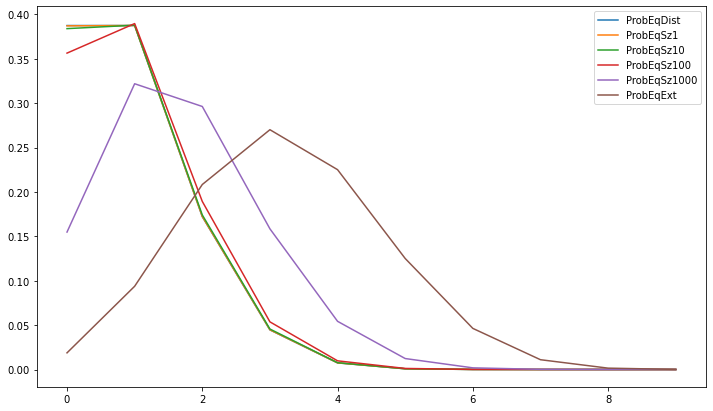

In [89]:
df_Probabilities = pd.concat([df_weighted_equally[['Probability']].astype(float).rename(columns={"Probability": "ProbEqDist"}),
           df_weightedSz1[['Probability']].astype(float).rename(columns={"Probability": "ProbEqSz1"}),
           df_weightedSz10[['Probability']].astype(float).rename(columns={"Probability": "ProbEqSz10"}),
           df_weightedSz100[['Probability']].astype(float).rename(columns={"Probability": "ProbEqSz100"}),
           df_weightedSz1000[['Probability']].astype(float).rename(columns={"Probability": "ProbEqSz1000"}),
           df_weightedExt[['Probability']].astype(float).rename(columns={"Probability": "ProbEqExt"})]
        ,axis=1)

df_Probabilities.plot(figsize=(12,7))
plt.show()

...

In [77]:
pd.options.display.float_format = "{:,.10f}".format
df_Probabilities

,ProbEqDist,ProbEqSz1,ProbEqSz10,ProbEqSz100,ProbEqSz1000,ProbEqExt
0,0.3874204926,0.3870504445,0.3839140866,0.3563387876,0.1547967704,0.0187512517
1,0.3874204926,0.3874614316,0.3877943891,0.3896123146,0.3218436803,0.0937562592
2,0.1721868839,0.1723879344,0.1740950444,0.1893212284,0.2962438637,0.2083472413
3,0.0446410440,0.0447406248,0.0455919349,0.0536614472,0.1584466959,0.2700797573
4,0.0074401740,0.0074646886,0.0076754535,0.0097773151,0.0542691936,0.2250664644
5,0.0008266860,0.0008302905,0.0008614473,0.0011875867,0.0123442258,0.1250369247
6,0.0000612360,0.0000615683,0.0000644558,0.0000961611,0.0018647682,0.0463099721
7,0.0000029160,0.0000029349,0.0000031003,0.0000050053,0.0001804068,0.0110261838
8,0.0000000810,0.0000000816,0.0000000870,0.0000001520,0.0000101429,0.0015314144
9,0.0000000010,0.0000000010,0.0000000011,0.0000000021,0.0000002525,0.0000945318


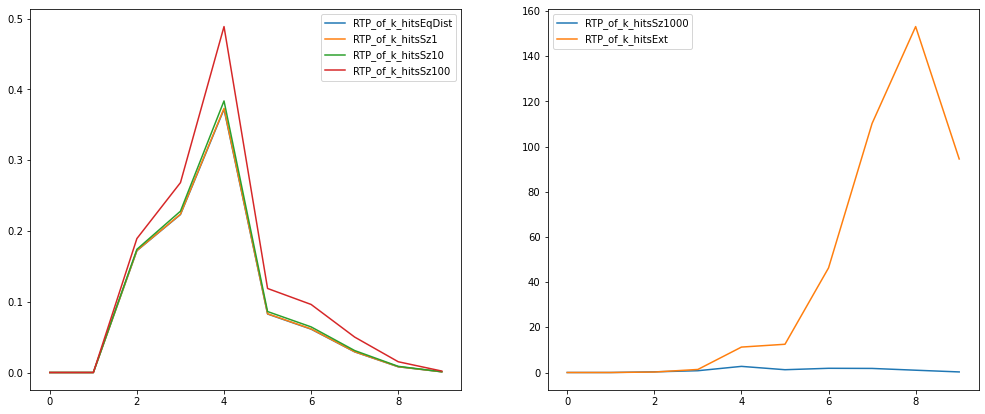

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_RTP_of_k_hits = pd.concat([df_weighted_equally[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsEqDist"}),
           df_weightedSz1[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSz1"}),
           df_weightedSz10[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSz10"}),
           df_weightedSz100[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSz100"}),
           df_weightedSz1000[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSz1000"}),  
           df_weightedExt[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsExt"})
        ],axis=1)

df_RTP_of_k_hits[['RTP_of_k_hitsEqDist','RTP_of_k_hitsSz1','RTP_of_k_hitsSz10','RTP_of_k_hitsSz100']].plot(figsize=(18,7), ax=axes[0])
df_RTP_of_k_hits[['RTP_of_k_hitsSz1000','RTP_of_k_hitsExt']].plot(figsize=(17,7), ax=axes[1])
plt.show()

...

In [83]:
df_RTP_of_k_hits

,RTP_of_k_hitsEqDist,RTP_of_k_hitsSz1,RTP_of_k_hitsSz10,RTP_of_k_hitsSz100,RTP_of_k_hitsSz1000,RTP_of_k_hitsExt
0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,0.1721868839,0.1723879344,0.1740950444,0.1893212284,0.2962438637,0.2083472413
3,0.2232052199,0.2237031240,0.2279596743,0.2683072358,0.7922334793,1.3503987867
4,0.3720087000,0.3732344292,0.3837726744,0.4888657547,2.7134596821,11.2533232185
5,0.0826686000,0.0830290526,0.0861447348,0.1187586710,1.2344225767,12.5036924653
6,0.0612360000,0.0615683066,0.0644558153,0.0961611369,1.8647681654,46.3099720940
7,0.0291600000,0.0293493715,0.0310034397,0.0500527774,1.8040677748,110.2618383191
8,0.0081000000,0.0081612596,0.0086991011,0.0151968467,1.0142887201,153.1414421098
9,0.0010000000,0.0010086330,0.0010848170,0.0020505780,0.2525014480,94.5317543890
